In [1]:
# Install required packages
!pip install transformers datasets torch tensorflow scikit-learn pandas numpy matplotlib seaborn wordcloud nltk lime
!pip install google-cloud-aiplatform
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha2

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from datasets import load_dataset
import tensorflow as tf
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [11]:
import pandas as pd
import re

# Mount Google Drive or upload files manually
from google.colab import files
uploaded = files.upload()

# Load CSVs
real1 = pd.read_csv('PolitiFact_real_news_content.csv')
fake1 = pd.read_csv('PolitiFact_fake_news_content.csv')
real2 = pd.read_csv('True.csv')
fake2 = pd.read_csv('Fake.csv')

# Assign binary labels
real1['label'] = 0
real2['label'] = 0
fake1['label'] = 1
fake2['label'] = 1

# Select and rename text column
real1['cleaned_text'] = real1['text']
fake1['cleaned_text'] = fake1['text']
real2['cleaned_text'] = real2['text']
fake2['cleaned_text'] = fake2['text']

# Combine relevant columns
df = pd.concat([
    real1[['cleaned_text', 'label']],
    fake1[['cleaned_text', 'label']],
    real2[['cleaned_text', 'label']],
    fake2[['cleaned_text', 'label']]
], ignore_index=True)

# Clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove non-alphanum chars
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    return text.strip().lower()

df['cleaned_text'] = df['cleaned_text'].astype(str).apply(clean_text)

# Final check
print("Dataset size:", df.shape)
print(df['label'].value_counts())
df.head()


Saving True.csv to True (2).csv
Saving Fake.csv to Fake (2).csv
Saving PolitiFact_fake_news_content.csv to PolitiFact_fake_news_content (2).csv
Saving PolitiFact_real_news_content.csv to PolitiFact_real_news_content (2).csv
Dataset size: (45138, 2)
label
1    23601
0    21537
Name: count, dtype: int64


,cleaned_text,label
0,168k shares share this story hillary clinton j...,0
1,famous dog killed in spot she waited a year fo...,0
2,story highlights the house oversight panel vot...,0
3,we are absolutely heartbroken to hear about th...,0
4,nine years ago a driver lost control of his pi...,0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


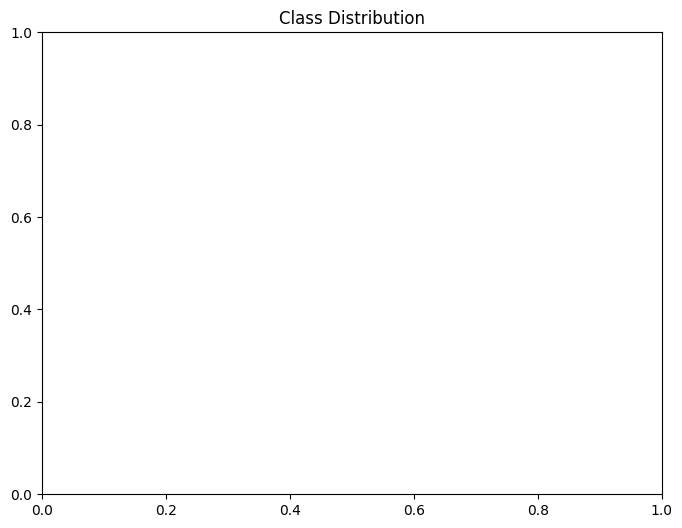


Data after cleaning:
Total rows: 0
Empty DataFrame
Columns: [cleaned_text, label]
Index: []


In [10]:
import nltk
import shutil
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Clear existing NLTK data and redownload
nltk.data.path.clear()
nltk.download('punkt', force=True, quiet=True)
nltk.download('stopwords', force=True, quiet=True)
nltk.download('wordnet', force=True, quiet=True)
nltk.download('omw-1.4', force=True, quiet=True)

# Verify Punkt is properly installed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    # If still not found, try alternative download method
    nltk.download('punkt', download_dir='/root/nltk_data', force=True)
    nltk.data.path.append('/root/nltk_data')

# Text cleaning function with robust tokenization fallback
def clean_text(text):
    try:
        # Convert to string and lowercase
        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove user references and hashtags
        text = re.sub(r'\@\w+|\#', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenization with fallback
        try:
            word_tokens = word_tokenize(text)
        except:
            # Simple whitespace tokenizer fallback
            word_tokens = text.split()

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in word_tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

        # Rejoin and clean whitespace
        text = ' '.join(lemmatized_words)
        text = re.sub(r'\s+', ' ', text).strip()

        return text if text else "empty_after_cleaning"

    except Exception as e:
        print(f"Error processing text (fallback used): {str(e)}")
        return "error_in_processing"

# Apply cleaning
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Remove rows with empty or error texts
df = df[~df['cleaned_text'].isin(["empty_after_cleaning", "error_in_processing"])]

# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

print("\nData after cleaning:")
print(f"Total rows: {len(df)}")
print(df.head())

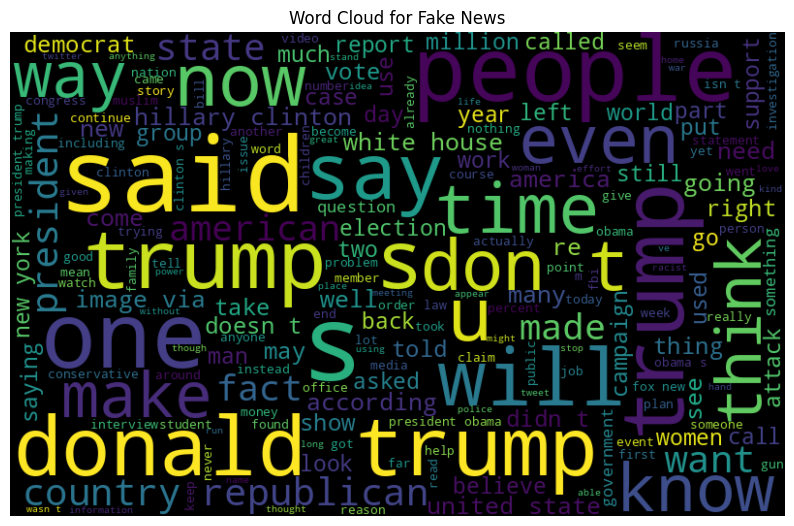

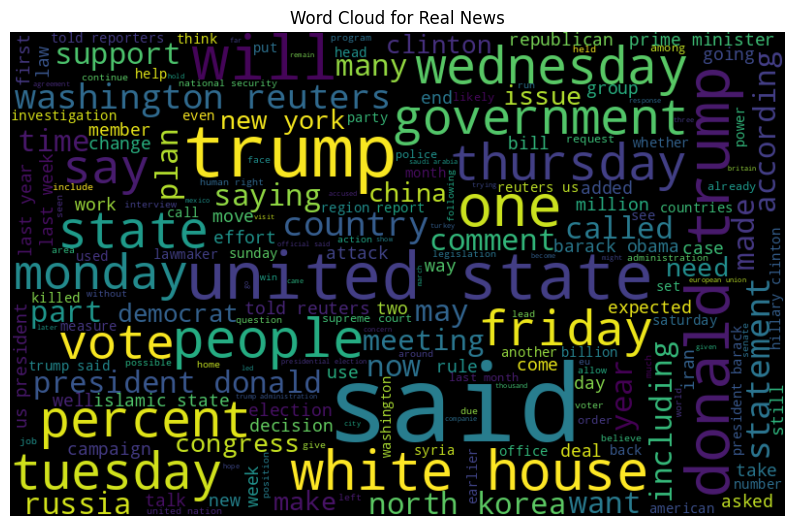

In [12]:
# Word cloud for fake news
fake_text = " ".join(df[df['label'] == 1]['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(fake_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Fake News')
plt.show()

# Word cloud for real news
real_text = " ".join(df[df['label'] == 0]['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(real_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Real News')
plt.show()

In [1]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize function
def tokenize_text(text, max_len=128):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

# Tokenize all texts
input_ids = []
attention_masks = []

for text in df['cleaned_text']:
    encoded = tokenize_text(text)
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

# Convert to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values)

# Split into train and validation sets
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function
def train_bert():
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        model.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

# Evaluation function
def evaluate_bert():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        total_eval_accuracy += (np.argmax(logits, axis=1) == label_ids).sum().item()

    avg_val_accuracy = total_eval_accuracy / len(val_dataset)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    return avg_val_loss, avg_val_accuracy

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_bert()
    val_loss, val_acc = evaluate_bert()

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

# Save the model
output_dir = "./bert_fake_news_model/"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

NameError: name 'BertTokenizer' is not defined

In [ ]:
# Function to predict with BERT
def predict_bert(text):
    encoded = tokenize_text(text)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_label = np.argmax(probabilities)

    return predicted_label, probabilities

# Test with sample text
sample_text = "The moon landing was faked by NASA in a Hollywood studio."
label, probs = predict_bert(sample_text)
print(f"Predicted: {'Fake' if label == 1 else 'Real'}")
print(f"Probabilities: [Real: {probs[0]:.4f}, Fake: {probs[1]:.4f}]")

# LIME explainer
class_names = ['Real', 'Fake']
explainer = LimeTextExplainer(class_names=class_names)

def bert_predict_proba(texts):
    preds = []
    for text in texts:
        _, probs = predict_bert(text)
        preds.append(probs)
    return np.array(preds)

# Explain a prediction
idx = 10
exp = explainer.explain_instance(df.iloc[idx]['cleaned_text'], bert_predict_proba, num_features=10)
exp.show_in_notebook(text=True)

In [ ]:
# Save TF-IDF model and vectorizer for traditional approach
import joblib

os.makedirs('models', exist_ok=True)
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

# For BERT model, we already saved it in the previous step

In [ ]:
def fake_news_detection_pipeline(text):
    """
    Complete pipeline for fake news detection
    Returns: prediction (str), probability (float), explanation (dict)
    """
    # Clean text
    cleaned_text = clean_text(text)

    # Get BERT prediction
    label, probs = predict_bert(cleaned_text)
    prediction = "Fake" if label == 1 else "Real"
    probability = probs[1] if label == 1 else probs[0]

    # Get explanation
    exp = explainer.explain_instance(
        cleaned_text,
        bert_predict_proba,
        num_features=5
    )
    explanation = dict(exp.as_list())

    return {
        "prediction": prediction,
        "probability": float(probability),
        "explanation": explanation
    }

# Test the complete pipeline
sample_news = """
Breaking: Scientists confirm COVID-19 was created in a lab as a bioweapon.
The virus was deliberately released to control population growth.
"""
result = fake_news_detection_pipeline(sample_news)
print("\nFake News Detection Result:")
print(f"Prediction: {result['prediction']}")
print(f"Probability: {result['probability']:.4f}")
print("Key Features Contributing to Prediction:")
for feature, weight in result['explanation'].items():
    print(f"- {feature}: {weight:.4f}")